# Pronosticos de Series de Tiempo
## ARIMA



### Importando librerias(funciones)

In [44]:
# Importar pquetes (funciones)
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
%matplotlib inline

# parametros de visualizaciones
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

### Obteniendo y transformando los datos

In [63]:
# Cargar datos

datos = pd.read_csv('AirPassengers.csv', engine='python')

# transformaciones de tiempo

datos['Mes']=pd.to_datetime(datos['Mes'], format='%Y-%m-%d')
datos.set_index(['Mes'], inplace=True)



### Graficando datos

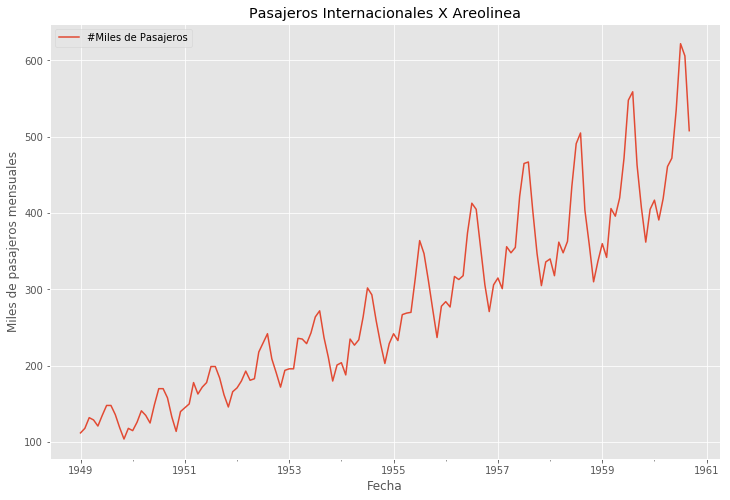

In [46]:
datos.plot(title='Pasajeros Internacionales X Areolinea')
plt.ylabel('Miles de pasajeros mensuales')
plt.xlabel('Fecha')
plt.show()

### Analisis Grafico de descomposicion

<Figure size 864x576 with 0 Axes>

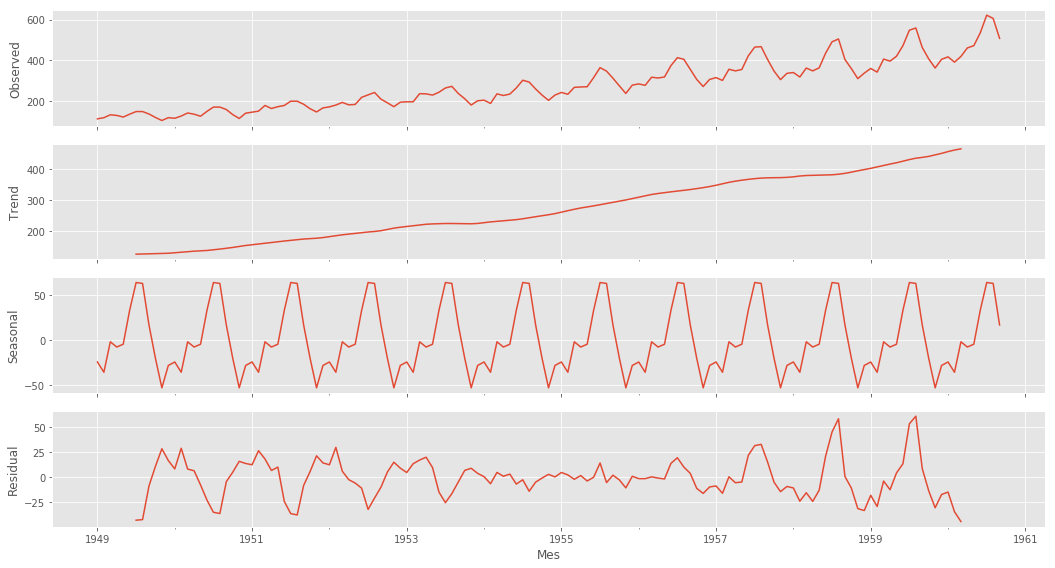

In [47]:
decomposition = seasonal_decompose(datos, freq=12)  #como determino la frecuencia de la estacionalidad
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8 )

Dos patrones evidentes aparecen en los datos, un aumento general en el número de pasajeros a lo largo del tiempo y una estacionalidad de 12 meses con picos correspondientes al período de verano en el norte de la emisferio.

## ARIMA
ARIMA significa Modelo autorregresivo integrado de media móvil. Hay tres enteros (p, d, q) que se utilizan para parametrizar los modelos ARIMA. Por eso, un modelo ARIMA no estacional se denota con ARIMA (p, d, q):

<ul>
<li><strong>p</strong> es el número de términos autorregresivos (parte AR). Permite incorporar el efecto de valores pasados en nuestro modelo. Intuitivamente, esto sería similar a afirmar que es probable que haga calor mañana si ha estado caliente los últimos 3 días.
<li><strong>d</strong> es el número de diferencias no estacionales necesarias para la estacionariedad. Intuitivamente, esto sería similar a afirmar que es probable que mañana haya la misma temperatura si la diferencia de temperatura en los últimos tres días ha sido muy pequeña.
<li><strong>q</strong> es el número de errores de pronóstico retrasados en la ecuación de predicción (parte de MA). Esto nos permite establecer el error de nuestro modelo como una combinación lineal de los valores de error observados en puntos de tiempo anteriores en el pasado.
</ul> 

Cuando se trata de efectos estacionales, como en nuestro ejemplo, se usa ARIMA estacional, que se denota como ARIMA (p, d, q) (P, D, Q) s. Aquí, (p, d, q) son los parámetros no estacionales descritos anteriormente, (P, D, Q) siguen la misma definición pero se aplican al componente estacional de la serie temporal. El término s es la periodicidad de la serie temporal.

Mientras que en este caso está claro que s = 12, ¿cómo establecemos los otros parámetros?

Está bastante basado en la experiencia. Existen numerosas prácticas recomendadas que se pueden seguir para identificar modelos ARIMA, como: http://people.duke.edu/~rnau/arimrule.htm.

Aquí utilizamos la búsqueda de cuadrícula en todas las combinaciones posibles de valores de parámetros dentro de un rango de valores predefinido 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$  devuelve valores para AIC (Criterio de información de Akaike) y BIC (Criterio de información de Bayes) que se pueden minimizar para seleccionar el mejor modelo de ajuste. Utilizamos el valor AIC, que estima la información perdida cuando se usa un modelo determinado para representar el proceso que genera los datos. Al hacerlo, se ocupa de la compensación entre la bondad de ajuste del modelo y la complejidad del propio modelo.

In [48]:
# Defina los parámetros d y q para tomar cualquier valor entre 0 y 1
q = d = range(0, 2)

# Define los parámetros p para tomar cualquier valor entre 0 y 3
p = range(0, 4)

# Generar todas las combinaciones diferentes de tripletas p, q y q
pdq = list(itertools.product(p, d, q))

# Generar todas las combinaciones diferentes de tripletas estacionales p, q y q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Ejemplos de combinaciones de parámetros para ARIMA estacional...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Ejemplos de combinaciones de parámetros para ARIMA estacional...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Profundizar en las construcion de modelo SARIMA

Seleccionamos un subconjunto de la serie de datos como datos de entrenamiento, digamos los primeros 11 años. Nuestro objetivo es predecir el último año de la serie en función de esta información.

In [66]:
datos_entrenamiento = datos['1949-01-01':'1959-12-01']
datos_simulacion = datos['1960-01-01':'1960-12-01']

In [50]:
warnings.filterwarnings("ignore") # especificar para ignorar los mensajes de advertencia

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [51]:
print('El minimo AIC es {} del modelo SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

El minimo AIC es 618.2055120323107 del modelo SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [52]:
# Vamos a ajustar este modelo
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

Una vez que el modelo ha sido ajustado, podemos verificar si cumple con lo que esperamos y si se violan las suposiciones que hicimos. Para eso, podems usar el metodo $plot\_diagnostics$.

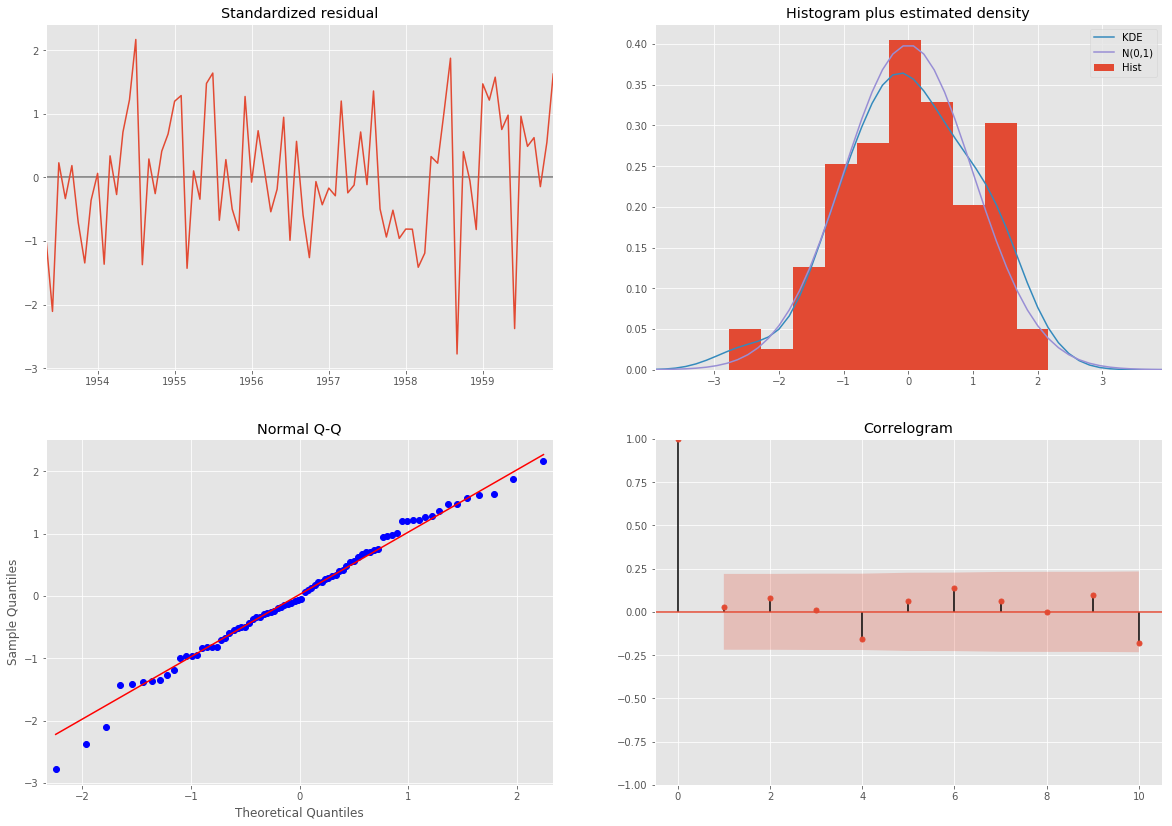

In [53]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

En los gráficos anteriores, podemos observar que los residuos no están correlacionados (gráfico inferior derecho) y no muestran una estacionalidad obvia (el gráfico superior izquierdo). Además, los residuos se distribuyen aproximadamente con la media cero (gráfico superior derecho). El gráfico qq en la parte inferior izquierda muestra que la distribución ordenada de los residuos (puntos azules) sigue muy bien la tendencia lineal de las muestras tomadas de una distribución normal estándar con N (0, 1). Nuevamente, esto es una fuerte indicación de que los residuos se distribuyen normalmente.

# Resultados
Ahora vamos a crear algunas predicciones. Utilizaremos tres métodos:

1)En predicción de muestra con pronostico de 1 paso por delante del año pasado (1959). En este caso, el modelo se utiliza para predecir los datos sobre los que se construyó el modelo. La previsión de 1 paso por delante implica que cada punto pronosticado se utiliza para predecir el siguiente. 

In [54]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

2)En predicción muestral con pronostico dinámico del último año (1959). Nuevamente, el modelo se usa para predecir datos sobre los que se construyó el modelo.

In [55]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

3)  Pronóstico "Verdadero" de datos de la muestra. En este caso, se le pide al modelo que prediga datos que no ha visto antes.

In [56]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493358
1960-02-01    397.831431
1960-03-01    460.856927
1960-04-01    449.448984
1960-05-01    474.553196
1960-06-01    537.847737
1960-07-01    614.883767
1960-08-01    628.208532
1960-09-01    519.334111
1960-10-01    462.252274
1960-11-01    412.161185
1960-12-01    452.661380
Freq: MS, dtype: float64


### Grafiquemos todo

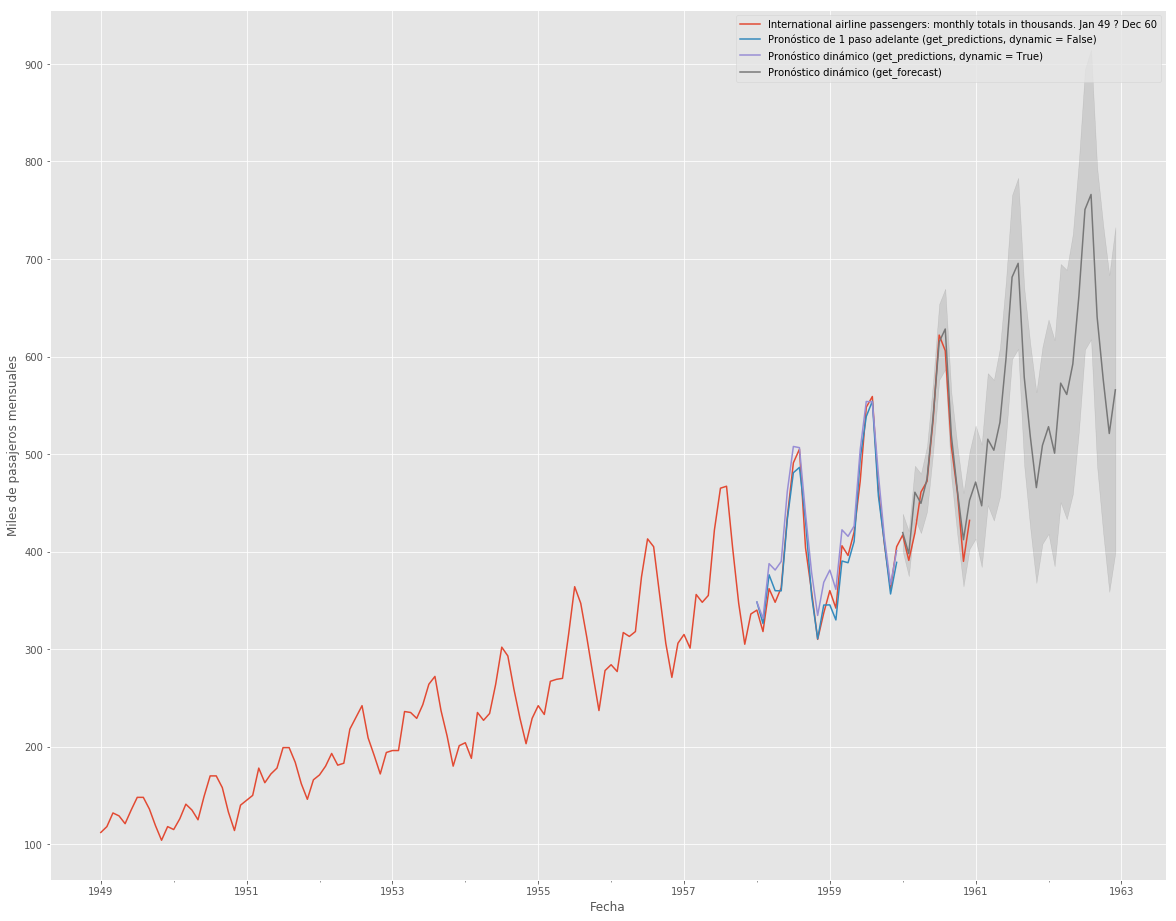

In [57]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='Pronóstico de 1 paso adelante (get_predictions, dynamic = False)')
pred1.predicted_mean.plot(ax=ax, label='Pronóstico dinámico (get_predictions, dynamic = True) ')
pred2.predicted_mean.plot(ax=ax, label='Pronóstico dinámico (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Miles de pasajeros mensuales')
plt.xlabel('Fecha')
plt.legend()
plt.show()

Mirando la figura, el modelo parece hacer un buen trabajo modelando las series de tiempo. Las líneas azul y púrpura están, como se esperaba, muy cerca de la verdad del fondo rojo. Lo que es más interesante es la línea gris, la predincción fuera de muestra. Para una serie de tiempo tan simple, el modelo ARIMA puede pronosticar los valores de 1960 con precisión.

Para cuantificar la precisión de la predicción para 1960, podemos calcular métricas como Error medio absoluto, Error medio cuadrático o Error medio cuadrático raíz. Estas son todas las métricas absolutas, por lo tanto son dependientes de la escala. Si bien son útiles y se usan ampliamente para comparar diferentes métodos en un mismo conjunto de datos, aquí sería más útil expresar el error en relación con la magnitud de las series de tiempo que intentamos predecir. Una medida de error porcentual comúnmente utilizada es el Error de porcentaje absoluto promedio (MAPE). Tiene algunos inconvenientes en casos especiales (en particular, puede llevar a una división por cero) y se han propuesto medidas mejoradas, ver, por ejemplo

In [68]:

pronostico = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
datos_test = list(itertools.chain.from_iterable(datos_simulacion.values))

mse = ((pronostico - datos_test) ** 2).mean()

MAPE = np.mean(np.abs((datos_test - pronostico) / datos_test)) * 100

print('El error cuadrático medio para el pronóstico del año 1960 es  {}'.format(round(mse, 2)))
print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))
print('La raiz del error cuadrático medio de nuestros pronósticos es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio para el pronóstico del año 1960 es  295.4
The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%
La raiz del error cuadrático medio de nuestros pronósticos es 17.19
